# U.S. Geological Survey Class GW3099
Advanced Modeling of Groundwater Flow (GW3099)\
Boise, Idaho\
September 16 - 20, 2024

![title](../../images/ClassLocation.jpg)

# GWE Example 1 -- One-dimensional, transient heat transport with thermal conduction and steady advection (Stallman problem)

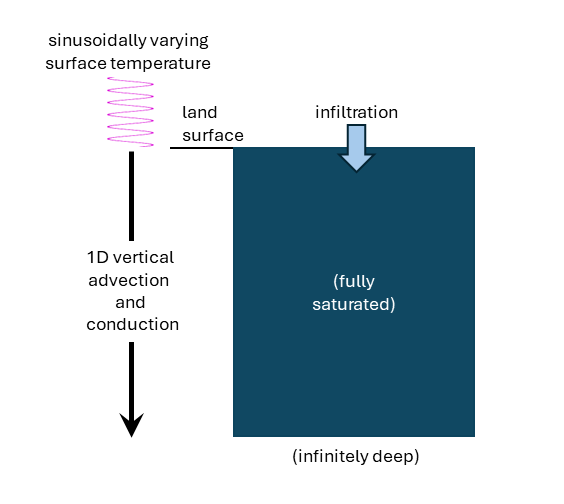

The first part of this example demonstrates the use of the Groundwater Energy (GWE) Model to simulate one-dimensional, transient thermal-energy (heat) transport in the subsurface in response to a cyclical (sinusoidally varying) land-surface temperature and downward, fully saturated, steady-state groundwater flow. Results are compared with the analytical solution of Stallman (1965, Journal of Geophysical Research), which is valid at long times, after the influence of the initial conditions has decayed away.

The second part of this example explores the analogy between heat transport and solute transport. A GWT solute-transport model is constructed with "surrogate" parameter values that allow it to emulate heat transport in this example.

To get the lay of the land, have a look at the overall organization of the notebook and the list of parameters near the beginning, then work the exercises.

### Preliminaries

In [1]:
import pathlib as pl

import flopy
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

# Example name and workspace paths
example_name = "gwe-ex1-stallman"
sim_ws = pl.Path(example_name)
figs_path = sim_ws

### Set constants for convenience

In [2]:
sec_in_yr = 60 * 60 * 24 * 365.25  # number of seconds in a year

### Set parameters to base-case values

In [3]:
# Model units
length_units = "meters"
time_units = "seconds"

# Grid parameters
nlay = 200 + 1  # Number of layers (the +1 is for an extra, very thin cell at the top)
nrow = 1  # Number of rows
ncol = 1  # Number of columns
delr = 1.0  # Column width ($m$)
delc = 1.0  # Row width ($m$)
top = 0.0  # Top elevation of the model (land surface) ($m$)
bot = -100.0  # Bottom elevation of model ($m$)

# Flow parameters
hydraulic_conductivity = 1.0e-4  # Hydraulic conductivity (m / s)
darcy_flux = 5.00e-07  # Darcy flux, a.k.a. specific discharge (m / s)

# Heat-transport parameters
porosity = 0.35  # Porosity (unitless)
rho_w = 1000  # Density of water (kg / m^3)
rho_s = 2630  # Density of solid (kg / m^3)
c_w = 4174  # Specific heat of water (J / kg / deg_C)
c_s = 800  # Specific heat of solid (J / kg / deg_C)
k_w = 0.58  # Thermal conductivity of water (J / s / m / deg_C)
k_s = 2  # Thermal conductivity of solid (J / s / m / deg_C)
alphal = 0.0  # Longitudinal dispersivity (m)
alphat = 0.0  # Transverse dispersivity (m)

# Surface-temperature parameters
T_az = 10  # Ambient temperature (deg_C)
dT = 5  # Amplitude of surface-temperature cycle (deg_C)
tau = 1.0 * sec_in_yr  # Duration (period) of surface-temperature cycle (s)

# Simulation timing parameters
ntau = 6  # Number of surface-temperature cycles to simulate
npertau = 60  # Number of stress periods per surface-temperature cycle
nstp = 6  # Number of time steps per stress period

# Solver parameters
nouter = 100  # maximum number of outer (nonlinear) iterations
ninner = 300  # maximum number of inner (linear) iterations
dvclose = 1e-8  # closure criterion (convergence tolerance) for dependent variable
rclose = 1e-8  # closure criterion (convergence tolerance) for residual
relax = 0.97  # relaxation factor

In [4]:
# Calculate number and length of stress periods
nper = ntau * npertau  # Total number of stress periods
perlen = tau / npertau  # Length of each stress period (s)

In [5]:
# Calculate bulk thermal properties and other thermal parameters
c_rho_w = c_w * rho_w  # Specific heat on per-volume basis for water (J / m^3 / deg_C)
c_rho_s = c_s * rho_s  # Specific heat on per-volume basis for solid (J / m^3 / deg_C)
c_rho_b = (
    porosity * c_rho_w + (1 - porosity) * c_rho_s
)  # Bulk specific heat on per-volume basis (J / m^3 / deg_C)
k_b = (
    porosity * k_w + (1 - porosity) * k_s
)  # Bulk thermal conductivity (J / s / m / deg_C)
alpha_b = k_b / c_rho_b  # bulk thermal diffusivity (m^2 / s)
c_rho_ratio = c_rho_w / c_rho_b  # ratio defined for convenience

In [6]:
# Calculate parameters for Stallman analytical solution
tpot = 2 * np.pi / tau
Kstal = np.pi / alpha_b / tau
Vstal = darcy_flux * c_rho_ratio / 2 / alpha_b
astal = ((Kstal**2 + Vstal**4 / 4) ** 0.5 + Vstal**2 / 2) ** 0.5 - Vstal
bstal = ((Kstal**2 + Vstal**4 / 4) ** 0.5 - Vstal**2 / 2) ** 0.5

### Calculate grid-layer bottoms

In [7]:
# Equally spaced grid-layer bottoms
nlay_equal = nlay - 1
delz = (top - bot) / nlay_equal
botm = []
for k in range(nlay_equal):
    botm.append(top - (k + 1) * delz)

# Split the topmost cell (layer) into two: a very thin cell above a cell
# of a-tiny-bit-less-than-normal thickness. The very thin cell at the top,
# whose node is very close to land surface, is where the surface-temperature
# boundary condition will be specified.
topmost_cell_thickness = 0.00002 * delz
topmost_cell_bottom = top - topmost_cell_thickness
botm[:0] = [topmost_cell_bottom]  # insert new cell bottom at front of list

### Define functions that prepare input data for MODFLOW models

In [8]:
def gwf_data():
    # Boundary-head data
    ztnode = 0.5 * (top + botm[0])
    zbnode = 0.5 * (botm[nlay - 2] + botm[nlay - 1])
    htnode = ztnode
    hgrad = -darcy_flux / hydraulic_conductivity
    hbnode = htnode - (zbnode - ztnode) * hgrad
    chd_data = {}
    for k in range(nper):
        chd_data[k] = [[(0, 0, 0), htnode], [(nlay - 1, 0, 0), hbnode]]

    return chd_data

In [9]:
def gwe_data():
    # Initial-temperature data (all cells at ambient temperature)
    Tstrt = T_az * np.ones((nlay, 1, 1), dtype=np.float32)

    # Data for land-surface temperature that varies sinusoidally with time
    ctp_data = {}
    for k in range(nper):
        t = (k + 1) * perlen
        Tsurf = T_az + dT * np.sin(tpot * t)
        ####T0 =  T_az + dT * np.sin(tpot * k * perlen)  # kluge use timeseries
        ####Tsurf = 0.5 * (T0 + Tsurf)                   # kluge
        ctp_data[k] = [[(0, 0, 0), Tsurf]]

    return Tstrt, ctp_data

### Define functions to build flow and transport models

Function to build groundwater-flow (GWF) model

In [10]:
def build_gwf_model(sim):
    print(f"Building GWF model for {sim.name}")

    # Construct some datasets
    chd_data = gwf_data()

    # Create the GWF model
    gwf = flopy.mf6.ModflowGwf(sim, modelname="GWF", save_flows=True)

    # Add iterative matrix solver (IMS) package
    ims = flopy.mf6.ModflowIms(
        sim,
        print_option="ALL",
        outer_dvclose=dvclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=dvclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwf.name}.ims",
    )
    sim.register_ims_package(ims, [gwf.name])

    # Add discretization (DIS) package
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )

    # Add node-property flow (NPF) package
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_specific_discharge=True,
        icelltype=0,
        k=hydraulic_conductivity,
    )

    # Add initial conditions (IC) package
    flopy.mf6.ModflowGwfic(gwf, strt=top)

    # Add constant-head boundary (CHD) package
    flopy.mf6.ModflowGwfchd(
        gwf,
        stress_period_data=chd_data,
    )

    # Add output-control (OC) package
    head_filerecord = f"{gwf.name}.hds"
    budget_filerecord = f"{gwf.name}.bud"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        # "LAST" generates output at the end of each stress period
        saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )

    return gwf

Function to build heat-transport (GWE) model

In [11]:
def build_gwe_model(sim):
    print(f"Building GWE model for {sim.name}")

    # Construct some datasets
    Tstrt, ctp_data = gwe_data()

    # Create the GWE model
    gwe = flopy.mf6.ModflowGwe(sim, modelname="GWE")

    # Add iterative matrix solver (IMS) package
    imsgwe = flopy.mf6.ModflowIms(
        sim,
        print_option="ALL",
        outer_dvclose=dvclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=dvclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwe.name}.ims",
    )
    sim.register_ims_package(imsgwe, [gwe.name])

    # Add discretization (DIS) package
    flopy.mf6.ModflowGwedis(
        gwe,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )

    # Add energy-storage (EST) package
    flopy.mf6.ModflowGweest(
        gwe,
        porosity=porosity,
        heat_capacity_solid=c_s,
        density_solid=rho_s,
        heat_capacity_water=c_w,
        density_water=rho_w,
    )

    # Add initial conditions (IC) package
    flopy.mf6.ModflowGweic(gwe, strt=Tstrt)

    # Add advection (ADV) package
    flopy.mf6.ModflowGweadv(gwe, scheme="TVD")

    # Add conduction & dispersion (CND) package
    flopy.mf6.ModflowGwecnd(
        gwe, xt3d_off=True, alh=alphal, ath1=alphat, ktw=k_w, kts=k_s
    )

    # Add source & sink mixing (SSM) package
    flopy.mf6.ModflowGwessm(gwe, sources=[[]])

    # Add constant-temperature (CTP) package
    flopy.mf6.ModflowGwectp(
        gwe,
        stress_period_data=ctp_data,
    )

    # Add output-control (OC) package
    flopy.mf6.ModflowGweoc(
        gwe,
        budget_filerecord=f"{gwe.name}.cbc",
        temperature_filerecord=f"{gwe.name}.ucn",
        temperatureprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        # "LAST" generates output at the end of each stress period
        saverecord=[("TEMPERATURE", "LAST")],
        printrecord=[("TEMPERATURE", "LAST"), ("BUDGET", "LAST")],
    )

    # Build GWF-GWE exchange
    gwfgwe = flopy.mf6.ModflowGwfgwe(
        sim, exgtype="GWF6-GWE6", exgmnamea=gwf.name, exgmnameb=gwe.name
    )

    return gwe

Function to build solute-transport (GWT) model that emulates heat transport

In [12]:
def build_gwt_model(sim, bulk_density=1, distcoef=1, diffc=1):
    print(f"Building GWT model for {sim.name}")

    # Construct some datasets
    Tstrt, ctp_data = gwe_data()

    # Create the GWT model
    gwt = flopy.mf6.ModflowGwt(sim, modelname="GWT")

    # Add iterative matrix solver (IMS) package
    imsgwt = flopy.mf6.ModflowIms(
        sim,
        print_option="ALL",
        outer_dvclose=dvclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=dvclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwt.name}.ims",
    )
    sim.register_ims_package(imsgwt, [gwt.name])

    # Add discretization (DIS) package
    flopy.mf6.ModflowGwtdis(
        gwt,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )

    # Add mobile storage & transfer (MST) package
    flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=porosity,
        sorption="linear",
        bulk_density=bulk_density,
        distcoef=distcoef,
    )

    # Add initial conditions (IC) package
    flopy.mf6.ModflowGwtic(gwt, strt=Tstrt)

    # Add advection (ADV) package
    flopy.mf6.ModflowGwtadv(gwt, scheme="TVD")

    # Add dispersion (DSP) package
    flopy.mf6.ModflowGwtdsp(gwt, xt3d_off=True, alh=alphal, ath1=alphat, diffc=diffc)

    # Add source & sink mixing (SSM) package
    flopy.mf6.ModflowGwtssm(gwt, sources=[[]])

    # Add constant-concentration (CNC) package
    flopy.mf6.ModflowGwtcnc(
        gwt,
        stress_period_data=ctp_data,
    )

    # Add output-control (OC) package
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{gwt.name}.cbc",
        concentration_filerecord=f"{gwt.name}.ucn",
        concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        # "LAST" generates output at the end of each stress period
        saverecord=[("CONCENTRATION", "LAST")],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    )

    # Build GWF-GWT exchange
    gwfgwt = flopy.mf6.ModflowGwfgwt(
        sim, exgtype="GWF6-GWT6", exgmnamea=gwf.name, exgmnameb=gwt.name
    )

    return gwt

### Define function to run simulation and return simulated temperatures

In [13]:
def run_sim():
    # Run simulation
    sim.run_simulation(silent=True)

    # Get node and store elevations
    zout = gwf.modelgrid.zcellcenters.flatten()

    # Get and store simulated GWE temperatures
    Tout = []
    Tout.append(gwe.output.temperature())

    # Optionally get and store simulated GWT "temperatures"
    if fake_it_with_gwt:
        Tout.append(gwt.output.concentration())

    return zout, Tout

### Define function to evaluate Stallman's analytical solution

In [14]:
def Stallman(t, zvalues):
    # Evaluate Stallman's analytical solution for temperature
    # at time t and a list of z (elevation) values
    Tstal = np.zeros((len(zvalues)))
    for i in range(len(zvalues)):
        depth = -zvalues[i]
        Tstal[i] = T_az + dT * np.exp(-astal * depth) * np.sin(tpot * t - bstal * depth)
    return Tstal

### Define functions to extract and plot results

In [15]:
def label_marker():
    # Set plot labels and markers
    label = ["Analytical solution"]
    marker = ["k--"]
    label.append("GWE")
    marker.append("bo")  # blue circles for GWE
    if fake_it_with_gwt:
        label.append("GWT")
        marker.append("r+")  # red plusses for GWT

    return label, marker

Function to extract results for plotting at the end of a particular stress period or all stress periods. Argument kper can set to either a single stress period number or the string "all".

In [16]:
def extract_results(zout, Tout, kper="all"):
    # If present, argument kper must be either an integer or the string "all";
    # there is no error check for this; if not present, the default is "all"

    # Set time(s)
    if kper == "all":
        tplot = np.array(Tout[0].get_times())  # list that contains all times
    else:
        tplot = [
            np.array(Tout[0].get_times())[kper]
        ]  # list that contains only one time

    # Extract temperature data
    Tplot = []
    Tplot0 = []
    for t in tplot:
        Tplot0.append(Stallman(t, zout))
    Tplot.append(np.array(Tplot0))
    for idx in range(len(Tout)):
        if kper == "all":
            Tplot.append(Tout[idx].get_alldata().reshape(Tplot[0].shape))
        else:
            Tplot.append([Tout[idx].get_data(totim=tplot[0]).flatten()])
    Tplot = np.array(Tplot)

    return tplot, Tplot

Function to plot or animate temperature profiles. If list of times tplot contains only one time, a static plot is generated. If tplot contains more than one time, an animation is generated.

In [17]:
def plot_temperature_profiles(tplot, Tplot, zplot, framestride=1):
    if len(tplot) > 1:
        # Make animation of multiple times
        animate = True
    else:
        # Make static plot of one time
        animate = False

    # Set labels and markers
    label, marker = label_marker()

    # Create figure
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlim(T_az - dT, T_az + dT)
    ax.set_ylim(bot, top)
    ax.set_ylabel("z (m)")
    ax.set_xlabel("Temperature (deg C)")

    # Function that updates the plot
    def update(kplot):
        for idx in range(len(Tplot)):
            graph[idx].set_data(Tplot[idx, kplot, :], zplot)
        t = tplot[kplot]
        ax.set_title("Time = {:.1f} seconds ({:.4f} years)".format(t, t / sec_in_yr))

    # Set/initialize plot data and title and create legend
    graph = [0] * len(Tplot)
    for idx in reversed(range(len(Tplot))):  # reversed so graph[0] is plotted on top
        graph[idx] = ax.plot(
            [], [], marker[idx], mfc="none", label=label[idx], linewidth=1.0
        )[0]
    update(0)
    ax.legend(loc="lower left")

    if animate:
        # Create animation
        frames = range(0, tplot.shape[0], framestride)
        ani = animation.FuncAnimation(fig, update, frames=frames)
        fpth = figs_path / f"{example_name}-temperature.gif"
        ani.save(fpth, fps=5)
        print("Animated gif saved to", fpth)
        plt.close()

        return ani

    else:
        plt.show()
        fpth = figs_path / f"{example_name}-temperature.png"
        fig.savefig(fpth)
        print("Figure is saved to", fpth)

        return

### Create simulation and add models and exchange

In [18]:
# Create simulation
sim = flopy.mf6.MFSimulation(
    sim_name=example_name,
    sim_ws=sim_ws,
    exe_name="mf6",
)

# Add time discretization (TDIS) package
per_data = []
for kper in range(nper):
    per_data.append((perlen, nstp, 1.0))
flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=per_data, time_units=time_units)

# Build flow model
gwf = build_gwf_model(sim)

# Build transport GWE model and exchange
gwe = build_gwe_model(sim)

fake_it_with_gwt = False  # for now a GWT "surrogate" model model is not included

Building GWF model for gwe-ex1-stallman
Building GWE model for gwe-ex1-stallman


### Write simulation

In [19]:
sim.write_simulation(silent=True)

## Exercise A -- Time scales

__For definitions of the parameters you encounter below, you can refer to the lists of specified and calculated parameters near the beginning of this notebook.__

__A1.__ Run the simulation and plot the temperature profile using the next two notebook cells below as they are. What's the main reason we shouldn't necessarily expect the plotted GWE model results to agree with the analytical solution very well? (Partial spoiler in part A2.)

__You won't need to rerun the simulation for the remainder of Exercise A - just rerun the notebook cell that extracts and plots the temperature profiles.__

__A2.__ Based on eyeballing plots you make with different values of ktau, about how many annual surface-temperature cycles (i.e., how many years) does it take until the agreement down to __60 m depth__ becomes pretty good (but remains not as good below that)? This is how long it takes the effect of the surface-temperature variation to essentially fully penetrate to 60 m depth by a combination of advection in the water and conduction in the water and the solid aquifer material, and effectively "flush out" the effects of the initial conditions to that depth.

__A3.__ Let's estimate the expected times required for a temperature signal at land surface to traverse the top 60 m of the model domain by advection and by conduction. Advection at velocity v traverses a distance L in time
<blockquote>
t_adv = L / v
</blockquote>
and the characteristic time for conduction over a distance L is
<blockquote>
t_cond = L**2 / alpha_b <br>
</blockquote>
where L**2 is L squared and alpha_b is the bulk thermal diffusivity. The advective velocity is related to our specified Darcy flux by
<blockquote>
    v = darcy_flux / porosity <br>
</blockquote>
There's also a pre-calculated conversion factor called sec_in_yr you can use to convert seconds to years. Feel free to create a new notebook cell in which to do these characteristic time calculations. Based on these times, which transport mechanism - advection or conduction - is dominant in this problem? (Spoiler in A4 below.) This is the process that's primarily controlling penetration of the surface-temperature signal into the subsurface.

__A4.__ How does the characteristic time for the dominant transport mechanism (advection) calculated in A3 compare with the penetration time determined in A2? Characteristic times are ballpark estimates based on generic scaling arguments, so we don't necessarily expect exact agreement. That said, we can probably do better. What does that characteristic time from A3 fail to take into account? (Spoiler in A5 below.)

__A5.__ Sorption of solute onto solid aquifer material effectively slows the rate of solute transport. The factor by which transport is slowed is called the "retardation factor" and is greater than or equal to 1. In heat transport, storage of heat in the solid is analogous to sorption in the sense that heat distributes itself between the water and the solid. In the MODFLOW 6 GWE Model, the water and solid are assumed to be at the same temperature (at thermal equilibrium) at any given point in the model, so heat storage in the solid is analogous to equilibrium sorption.  One can, in fact, define a "thermal retardation factor" by which heat transport is slowed due to storage of heat in the solid. Under the assumptions inherent in this example problem, the thermal retardation factor is
<blockquote>
R_T = 1 / porosity / c_rho_ratio <br>
</blockquote>
Calculate R_T for this example. Does accounting for retardation bring the estimated characteristic time for the dominant transport mechanism closer to the penetration time from from A2?

__A6.__ Replot the temperature profile for ktau = 6, which is the end of the simulation. This should produce decent agreement throughout the model domain.

In [20]:
# You only need to run this notebook cell once to do Exercise A.
# No harm in rerunning it, except it'll take time.

# Run simulation
zout, Tout = run_sim()
# zout is a list of node elevations at which temperature was calculated
# Tout[0] contains temperature output from GWE model at the end of each stress period

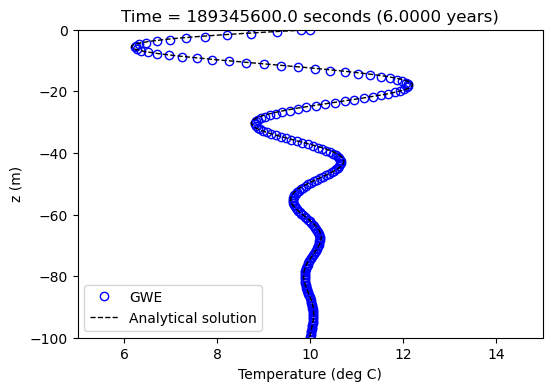

Figure is saved to gwe-ex1-stallman\gwe-ex1-stallman-temperature.png


In [21]:
# This is the notebook cell you'll rerun with ktau set to different values.
# Increments of 0.5 are good enough (e.g., ktau = 1.5; 1.58 would be overkill
# for our purposes).

# Extract temperature profiles at the end of ktau surface-temperature cycles.
# The value of ktau can be fractional (e.g., 1.5); the resulting stress period
# number is rounded to the nearest integer.
ktau = 6  # number of surface-temperature cycles (can be fractional)
kper = (
    round(ktau * npertau) - 1
)  # "- 1" because stress period numbering is 0-based here
tplot, Tplot = extract_results(zout, Tout, kper)
# tplot is a list of times; in this case, only one time (end of stress period kper)
# Tplot is a numpy array of simulated temperatures at end of stress period kper

# Call plotting function, which will generate a static plot because tplot
# contains only one time. The function will automatically display the plot
# and save it to file.
plot_temperature_profiles(tplot, Tplot, zout)

In [22]:
print("simulated penetration time (yr): roughly 3.5")

# Calculations for A3

L = 60  # depth of interest (m)
v = darcy_flux / porosity  # linear velocity of flow (m / s)

t_adv = L / v / sec_in_yr  # characteristic time for advection (yr)
t_cond = L**2 / alpha_b / sec_in_yr  # characteristic time for conduction (yr)

print(
    "\ncharacteristic times from A3 (yr):",
    "\n\tadvection",
    t_adv,
    "\n\tconduction",
    t_cond,
)

# Calculations for A5

R_T = 1 / c_rho_ratio / porosity
t_adv *= R_T
t_cond *= R_T

print("\nretardation factor:", R_T)
print(
    "characteristic times adjusted for retardation in A5 (yr):",
    "\n\tadvection",
    t_adv,
    "\n\tconduction",
    t_cond,
)

simulated penetration time (yr): roughly 3.5

characteristic times from A3 (yr): 
	advection 1.330899688189216 
	conduction 214.68205121432547

retardation factor: 1.9361352590868646
characteristic times adjusted for retardation in A5 (yr): 
	advection 2.5768018126108547 
	conduction 415.65348884914755


## Exercise B -- Faking heat transport with a solute-transport model

To further explore the analogy between heat and solute transport, let's solve this problem using a GWT model instead of a GWE model. We'll do this by manipulating the input to the GWT model to trick it into essentially solving the same equation the GWE model does, and the resulting "concentrations" will be the temperature values we want to simulate.

The governing equations solved by the GWE and GWT models (including only the terms relevant to this problem) can be written as

$\left ( 1 + \frac{1}{\theta \left ( \rho C_{P} \right )_{b}} \right ) \frac{\partial T}{\partial t} = - v \frac{\partial T}{\partial z} + \frac{\alpha_b}{\theta \left ( \rho C_{P} \right )_{b}} \frac{{\partial}^{2} T}{\partial z^2}$

and

$\left ( 1 + \frac{\rho_b K_d}{\theta} \right ) \frac{\partial C}{\partial t} = - v \frac{\partial C}{\partial z} + D^{mol} \frac{{\partial}^{2} C}{\partial z^2}$

respectively, where

$T$ is temperature

$C$ is concentration, which we want to mimic temperature

$t$ is time

$z$ is elevation

$v$ is advective velocity

$\theta = $ porosity (previously defined parameter)

$\left ( \rho C_{P} \right )_{b} = $ c_rho_b (bulk volumetric heat capacity, previously defined parameter)

$\alpha_{b} = $ alpha_b (bulk thermal diffusivity, previously defined parameter)

$\rho_{b} = $ bulk density of the aquifer (mass of solid per volume of aquifer)

$K_{d} = $ distribution coefficient for linear sorption

$D^{mol} = $ molecular diffusion coefficient

To get the GWT model to solve the same equation for $C$ that the GWE model solves for $T$, we have to choose our GWT parameters such that the coefficients of corresponding terms have the same numerical values. You'll recognize the coefficients of the time-derivative (storage) terms as the retardation factors. To make the retardation factors equal, we need to set $\rho_b$ and $K_d$ such that

$1 + \frac{\rho_b K_d}{\theta} = 1 + \frac{1}{\theta \left ( \rho C_{P} \right )_{b}}$

Since it's only the product $\rho_b K_d$ that matters, we're free to set $\rho_{b}$ to its "real-life" value of

$\rho_{b} = \rho_{s} \left ( 1 - \theta \right )$

(where $\rho_{s} = $ rho_s, the solid density), for example, which makes the algebra to work out $K_d$ fairly straightforward. The coefficients of the advection terms already match, all that's left is to match the coefficient of the solute-diffusion term to the coefficient of the thermal-conduction term.

__A1.__ Run the next notebook cell below, which adds the GWT model and rewrites the whole simulation.

__You won't need to rerun the cell you just ran for the remainder of Exercise B.__

__A2.__ In the notebook cell after that, enter the appropriate formulas for the "surrogate" parameters, update the corresponding input files, run the simulation, and plot the results. If your GWT results don't agree with the others, fix your surrogate parameters and rerun the notebook cell.

In [23]:
# Run this notebook cell only once to add the GWT model

# Add a GWT model (and GWF-GWT exchange) to the simulation
gwt = build_gwt_model(sim)
fake_it_with_gwt = True

# Rewrite simulation
sim.write_simulation(silent=True)

Building GWT model for gwe-ex1-stallman


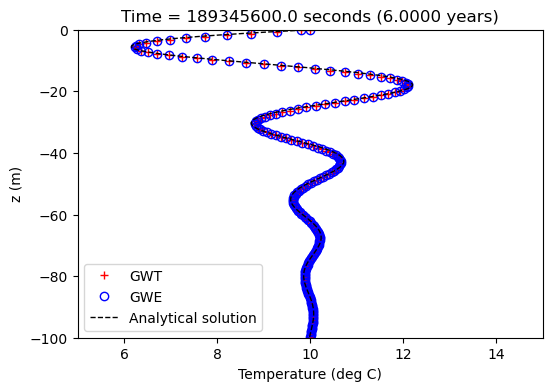

Figure is saved to gwe-ex1-stallman\gwe-ex1-stallman-temperature.png


In [29]:
# Here is where you change the surrogate parameter values.
# Run this notebook cell more than once if you need to.

# Calculate surrogate solute-transport parameters that allow
# the GWT Model to emulate heat transport
bulk_density = rho_s * (1 - porosity)  # Surrogate bulk density of aquifer
distcoef = c_s / c_rho_w  # Surrogate distribution coefficient
diffc = alpha_b / (porosity * c_rho_ratio)  # surrogate diffusion coefficient

# Update the GWT model with these surrogate parameters and rewrite the
# input files for the packages involved. These are the Mobile Storage and
# Transfer (MST) Package, which contains the sorption parameters, and
# the Dispersion (DSP) Package, which contains the diffusion coefficient.
gwt.mst.bulk_density = bulk_density
gwt.mst.distcoef = distcoef
gwt.mst.write()
gwt.dsp.diffc = diffc
gwt.dsp.write()

# Run simulation
zout, Tout = run_sim()
# zout is a list of node elevations at which temperature was calculated
# Tout[0] contains temperature output from GWE model at the end of each stress period
# Tout[1] contains temperature output from GWT model at the end of each stress period

# Extract temperature profiles at the end of ktau surface-temperature cycles.
# The value of ktau can be fractional (e.g., 1.5); the resulting stress period
# number is rounded to the nearest integer.
ktau = 6  # number of surface-temperature cycles (can be fractional)
kper = (
    round(ktau * npertau) - 1
)  # "- 1" because stress period numbering is 0-based here
tplot, Tplot = extract_results(zout, Tout, kper)
# tplot is a list of times; in this case, only one time (end of stress period kper)
# Tplot is a numpy array of simulated temperatures at end of stress period kper

# Call plotting function, which will generate a static plot because tplot
# contains only one time. The function will automatically display the plot
# and save it to file.
plot_temperature_profiles(tplot, Tplot, zout)

## Exercise C -- Animation and free play

__A1.__ Run the notebook cell below to create and display an animation of the temperature profiles. Get up and dance to the rhythm of the wave, or just kick back and chill for a while.

__A2.__ If you have time, feel free to play with the simulation parameters. Keep in mind that, depending on what you change, you might need to rerun the notebook from the beginning for your changes to take effect.

In [25]:
# Extract temperature profiles at all times
kper = "all"  # stress period number (0-based) at the end of which to plot
tplot, Tplot = extract_results(zout, Tout, kper)

# Call plotting function, which will generate an animation and save it to file
# and return it as an object, but will not display it. An additional command
# displays the animation. Parameter framestride controls what data are
# included in the animation - e.g., framestride=10 includes every 10th
# temperature profile. Makes the animation choppier but cuts down on the
# generation time and the gif file size.
ani = plot_temperature_profiles(tplot, Tplot, zout, framestride=10)
HTML(ani.to_jshtml())

Animated gif saved to gwe-ex1-stallman\gwe-ex1-stallman-temperature.gif
